<a href="https://colab.research.google.com/github/yanivt16/BDP_project/blob/main/Yaniv_Copy_of_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurations

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.1-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.1-bin-hadoop3.tgz 
!pip install findspark 

In [ ]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

In [ ]:
import findspark
import random
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('lr_example').getOrCreate()

In [ ]:
# Other imports
import numpy as np
import pyspark
from pyspark.rdd import RDD
from pyspark import SparkContext
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, IntegerType, StringType

from pyspark.sql.functions import *
from pyspark.sql.functions import substring
from pyspark.sql.functions import when
from pyspark.sql.functions import concat, lit, col
from pyspark.sql.functions import to_date

from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.functions import col

import warnings
warnings.filterwarnings("ignore")#Ignores all unfamiliar fonts
!pip install matplotlib==3.1.3
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,7)
import datetime



# Import Data

In [ ]:
df_pd = pd.read_csv('/content/-3-2022-.csv')

In [ ]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1d8b_n-6fo5HbxyW-kwY3c8fWlvLOcFYy/view?usp=share_link'
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('-3-2022-.csv') 
 
df_pd = pd.read_csv('-3-2022-.csv')
df_pd.info()

In [ ]:
# df = spark.read.csv("/tmp/resources/zipcodes.csv")


# Translate Data

In [ ]:
!pip install googletrans==4.0.0rc1 gwpy &> /dev/null

In [ ]:
from googletrans import Translator
translator = Translator()

In [ ]:
def translate_column (df:pd.DataFrame, name:str):
  y = 'he_' + name
  column_to_translate = pd.DataFrame(list(df[name].unique())).rename({0:y},axis=1)
  x = 'en_' + name
  column_to_translate[x] = column_to_translate[y].apply(lambda x: translator.translate(x, src='he', dest='en').text)
  df = df.merge(column_to_translate, left_on=name, right_on=y,how ='inner')
  df[name]=df[x]
  df=df.drop(columns=[x,y])
  return df

In [ ]:
en_df_pd = df_pd
column_names = en_df_pd.columns
k = column_names.delete([4,5,6,9])
for i in k:
  en_df_pd = translate_column(en_df_pd,i)
en_df_pd

In [ ]:
en_df_pd.to_csv('/content/en_df_pd.csv', index=False)

#Create Spark-DF

In [ ]:
spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("SparkByExamples.com") \
    .getOrCreate()
df = spark.createDataFrame(en_df_pd.astype(str))
df.printSchema()
df.show(5)

In [ ]:
df1 = df.withColumn("TikimSum",df.TikimSum.cast('int'))

In [ ]:
df2 = df1.withColumn('year', substring('Quarter', 1,4))\
    .withColumn('Q', substring('Quarter', 6,2))
df2.printSchema()
df2.show(truncate=False)

In [ ]:
df2 = df2.withColumn("year",df2.year.cast(StringType()))

In [ ]:
df3 = df2.withColumn("date", \
   when((df2.Q == 'Q2'), lit("-30-06"))\
   .when((df2.Q == 'Q3'), lit("-30-09"))\
   .when((df2.Q == 'Q4'), lit("-31-12"))\
   .otherwise(lit("-31-03")) \
  )

In [ ]:
df3.show(5)

In [ ]:
# df_date = df3.select(concat('year','date').alias("Exact Date"))
df3 = df3.withColumn("Exact Date", concat('year','date'))
df3.show(5)

In [ ]:
df3 = df3.withColumn("Date Value", to_date(df3['Exact Date'], "yyyy-dd-MM"))

In [ ]:
df3.write.parquet("/content/df3.parquet")

In [ ]:
df4 = spark.read.parquet("/content/df3.parquet")


In [ ]:
df4.show(5)
df4.printSchema()

In [ ]:
# df5 = df4.join(socio_economic_df, on='Settlement_Council', how='left')

In [ ]:
df.select('PoliceDistrict').distinct().collect() #this is the way how to know how many unique value in the attribute

In [ ]:
link = "https://drive.google.com/file/d/1RBkuTYpTQHl0EjhiteL3DjSLd5xUxvYa/view?usp=share_link"
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('city_data_.csv') 
 
citydata = spark.read.csv("city_data_.csv",inferSchema=True, header=True)

In [ ]:
citydata = citydata.withColumnRenamed("שם יישוב","Settlement_Council")
citydata = citydata.withColumnRenamed("סך הכל אוכלוסייה 2021","Population")
citydata = citydata.withColumnRenamed("תעתיק" , "City Name")

citydata.show(5)

In [ ]:
df3.show(5)

In [ ]:
city_df = citydata.select("Settlement_Council", "Population","City Name" )

# Join the selected columns from city_df with crimes_df on the 'city_name' column
df4 = df3.join(city_df, on='Settlement_Council', how='left')

In [ ]:
df4.show(5)

In [ ]:
link = "https://drive.google.com/file/d/1FRVWLJLf_h-vWivkEzvC5RJBiI5kRnPW/view?usp=share_link"
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('s_e_2019.csv') 
 
socio_economic_df = spark.read.csv("s_e_2019.csv",inferSchema=True, header=True)

In [ ]:
socio_economic_df.show(5)

In [ ]:
socio_economic_df = socio_economic_df.select(col("Settlement_Council"), col("City_Cluster_2019"))

# Join the selected columns from city_df with crimes_df on the 'city_name' column
df5 = df4.join(socio_economic_df, on='Settlement_Council', how='left')

In [ ]:
df5 = df5.withColumnRenamed("Settlement_Council", "Settlement_Council_Hebrew")
df5 = df5.withColumnRenamed("City Name", "Settlement_Council")

In [ ]:
df5.collect()[100000] ## show specific row

In [ ]:
df5.show()

In [ ]:
df5.printSchema()

# Base Analysis

In [ ]:
df_Tikim_City = df5.groupBy('Settlement_Council').sum('TikimSum')
df_Tikim_City = df_Tikim_City.join(city_df, on='Settlement_Council', how='left')
df_Tikim_City = df_Tikim_City.withColumn("Tikim by population",col("sum(TikimSum)")/ col("Population"))
df_Tikim_City = df_Tikim_City.sort("Tikim by population",ascending=False)
df_Tikim_City.select("Settlement_Council","Tikim by population").show(10)

In [ ]:
# # If the cell below doesn't work, run this:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [ ]:
sns.distplot(df_Tikim_City.toPandas()["Tikim by population"]);

In [ ]:
df_Tikim_District = df5.groupBy('PoliceDistrict','Date Value').sum('TikimSum')

In [ ]:
pd_Tikim_District = df_Tikim_District.toPandas()
pd_Tikim_District

In [ ]:
districts = pd.unique(pd_Tikim_District['PoliceDistrict'])
for d in districts:
  pd_district = pd_Tikim_District[pd_Tikim_District['PoliceDistrict'] == d]
  pd_district = pd_district.sort_values(by = 'Date Value')
  plt.plot(pd_district['Date Value'],pd_district['sum(TikimSum)'])
plt.legend(districts, loc="upper right")
plt.axvline(x=datetime.date(2020,4,8), color='black', linestyle='dashed')
plt.axvline(x=datetime.date(2021,3,31), color='black', linestyle='dashed')
plt.ylim([0,25000])
plt.show()

In [ ]:
df_tikim_district = df5.groupBy('PoliceDistrict','StatisticCrimeGroup','Date Value').sum('TikimSum')
# df_tikim_district = df5.join(df_tikim_district, on='StatisticCrimeGroup', how='left')
pd_tikim_district = df_tikim_district.where(df_tikim_district.PoliceDistrict == "Central district").toPandas()

In [ ]:
types = pd.unique(pd_tikim_district['StatisticCrimeGroup'])
for t in types:
  pd_type = pd_tikim_district[pd_tikim_district['StatisticCrimeGroup'] == t]
  pd_type = pd_type.sort_values(by = 'Date Value')
  plt.plot(pd_type['Date Value'],pd_type['sum(TikimSum)'])
plt.legend(types, loc="upper right")
plt.axvline(x=datetime.date(2020,4,8), color='black', linestyle='dashed')
plt.axvline(x=datetime.date(2021,3,31), color='black', linestyle='dashed')
plt.show()

In [ ]:
import datetime
district = ["Southern District", "Shay County", "Jerusalem District", "North District", "Beach district", "Central district", "Cell County"]
for i in range(7):
  pd_tikim_district = df_tikim_district.where(df_tikim_district.PoliceDistrict == district[i]).toPandas()
  types = pd.unique(pd_tikim_district['StatisticCrimeGroup'])
  for t in types:
    pd_type = pd_tikim_district[pd_tikim_district['StatisticCrimeGroup'] == t]
    pd_type = pd_type.sort_values(by = 'Date Value')
    plt.plot(pd_type['Date Value'],pd_type['sum(TikimSum)'])
  plt.legend(types, loc = "upper right")
  plt.axvline(x=datetime.date(2020,4,8), color='black', linestyle='dashed')
  plt.axvline(x=datetime.date(2021,3,31), color='black', linestyle='dashed')
  plt.title(district[i])
  plt.show()

# Establishing "Crime Score"

In [ ]:
crime_types = df5.select('StatisticCrimeGroup').distinct()
crime_types = crime_types.withColumn('Score',col('StatisticCrimeGroup'))
df5.select('StatisticCrimeGroup').distinct().show(17,False)

In [ ]:
crime_scores = {'The rest of the offenses':'1', 'Traffic violations': '2', 'Nan': '3', 'Permitted offenses': '1', 'Offenses against a person':'5', 'Confidence offenses': '3', 'Sex offenses': '5',\
                'Administrative offenses': '1', 'Economic offenses': '2', 'Public order offenses': '1', 'Offenses toward property': '3','Setup Sections': '1',\
                'Fraudulent offenses': '3','Offenses against body': '5','Offenses toward morality': '4','Unknown': '3', 'The rest of the rest': '1'}
crime_types_score = crime_types.replace(crime_scores,subset=['Score'])
crime_types_score.sort('Score',ascending=False).show(17,False)


In [ ]:
df5.where(df5['StatisticCrimeGroup'] == 'Unknown').count()

In [ ]:
# crime_scores = {'שאר עבירות':'1', 'עבירות תנועה': '2', 'nan': '3', 'עבירות רשוי': '1', 'עבירות נגד אדם':'5', 'עבירות בטחון': '3', 'עבירות מין': '5',\
#                 'עבירות מנהליות': '1', 'עבירות כלכליות': '2', 'עבירות סדר ציבורי': '1', 'עבירות כלפי הרכוש': '3','סעיפי הגדרה': '1',\
#                 'עבירות מרמה': '3','עבירות נגד גוף': '5','עבירות כלפי המוסר': '4','לא ידוע': '1', 'קבוצת כל השאר': '1'}
# crime_types_score = crime_types.replace(crime_scores,subset=['Score'])
# crime_types_score.show()


$P = $ the population number of the city

$n_i = $ number of specific crime group cases

$S_i = $ the score of the specific crime group

$$CrimeScore = \frac{1}{P}\sum_{i}{n_{i}\cdot S_{i}}$$

In [ ]:
df6 = df5.join(crime_types_score, on='StatisticCrimeGroup', how='left')
df6 = df6.withColumn("Total_Score",col("TikimSum") * col("Score"))
df6 = df6.groupBy('Settlement_Council').sum('Total_Score')
df_score_city = df5.join(df6, on='Settlement_Council', how='left')
df_score_city = df_score_city.withColumn("Score per population",col("sum(Total_Score)") / col("Population"))

In [ ]:
df_score_city.select("Settlement_Council",'City_Cluster_2019',"Score per population").distinct().sort("Score per population",ascending=False).show(10)

In [ ]:
# df_score_city.select('Settlement_Council','Population').filter(df_score_city.Population.isNull()).distinct().show(100)

In [ ]:
pd_score = df_score_city.select('Settlement_Council','City_Cluster_2019','Score per population').distinct().toPandas()
sns.regplot(pd_score['City_Cluster_2019'],pd_score['Score per population'],ci=0,line_kws={"color": "red"})

In [ ]:
sns.distplot(pd_score['Score per population']);

$N = $ overall number of cases in the city 

$n_i = $ number of specific crime group cases

$S_i = $ the score of the specific crime group

$$CrimeScore = \frac{1}{N}\sum_{i}{n_{i}\cdot S_{i}}$$

In [ ]:
df7 = df5.join(crime_types_score, on='StatisticCrimeGroup', how='left')
df7 = df7.withColumn("Total_Score",col("TikimSum") * col("Score"))
df8 = df7.groupBy('Settlement_Council').sum('Total_Score')
df9 = df7.groupBy('Settlement_Council').sum('TikimSum')
df_score_city2 = df9.join(df8, on='Settlement_Council', how='left')
df_score_city2 = df_score_city2.withColumn("Score per population2",col("sum(Total_Score)") / col("sum(TikimSum)"))

In [ ]:
df_score_city2.select("Settlement_Council","Score per population2").distinct().sort("Score per population2",ascending=False).show(10)

In [ ]:
df_score_city2 = df_score_city2.join(df5.select('Settlement_Council','City_Cluster_2019'), on='Settlement_Council', how='left')

In [ ]:
pd_score2 = df_score_city2.select('Settlement_Council','City_Cluster_2019','Score per population2').distinct().toPandas()
sns.regplot(pd_score2['City_Cluster_2019'],pd_score2['Score per population2'],ci=0,line_kws={"color": "red"})

In [ ]:
sns.distplot(pd_score2['Score per population2']);

$P = $ the population number of the city

$N = $ overall number of cases in the city 

$n_i = $ number of specific crime group cases

$S_i = $ the score of the specific crime group

$$CrimeScore = \frac{1}{2} \cdot (\frac{1}{P}\sum_{i}{n_{i}\cdot S_{i}} + \frac{1}{N}\sum_{i}{n_{i}\cdot S_{i}})$$


In [ ]:
# df_score_city3 = df_score_city.select("Settlement_Council","Score per population").join(df_score_city2, on="Settlement_Council", how="left")
# df_score_city3 = df_score_city3.withColumn("Average Crime Score",(col("Score per population") + col("Score per population2"))/2)
# pd_score3 = df_score_city3.select('City_Cluster_2019','Average Crime Score').distinct().toPandas()
# sns.regplot(pd_score3['City_Cluster_2019'],pd_score3['Average Crime Score'],ci=0,line_kws={"color": "red"})

# Deeper analysis and prediction

In [ ]:
# Building data that will fit prediction over time.
years = ['2017', '2018', '2019', '2020', '2021', '2022']
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
df_ml = df5.select("Settlement_Council","Population","City_Cluster_2019").distinct().dropna()
for year in years:
  for q in quarters:
    if year == '2022' and q == 'Q4': # Skipping because there is no data for this time
      break
    year_q = year+"_"+q
    df_by_time = df5.groupBy('Settlement_Council','year','Q').sum('TikimSum')
    df_by_time = df_by_time.withColumnRenamed('sum(TikimSum)',year_q)
    df_temp = df_by_time.where(df_by_time.year == year)
    df_temp = df_temp.where(df_by_time.Q == q)
    df_ml = df_ml.join(df_temp.select('Settlement_Council',year_q),on='Settlement_Council', how='left')

In [ ]:
df_ml.show(5)

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
training_columns = df_ml.columns[1:-1] # Removing the city name and the last quarter of 2022 ("2022-Q3") from the training columns

In [ ]:
# Create a feature vector by combining the columns
df_ml = df_ml.dropna()
vector_assembler = VectorAssembler(inputCols=training_columns, outputCol="features", handleInvalid="keep")
df_ml_vec = vector_assembler.transform(df_ml)

In [ ]:
# Split the data into training and testing sets
df_ml_data = df_ml_vec.select("Settlement_Council","features","2022_Q3")
training_data, testing_data = df_ml_data.randomSplit([0.8, 0.2])

In [ ]:
# Train the linear regression model
lr = LinearRegression(featuresCol="features", labelCol="2022_Q3")
model = lr.fit(training_data)

In [ ]:
# Use the model to make predictions on the testing data
predictions = model.transform(testing_data)
predictions.show(5)

In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol='2022_Q3')
evaluator.evaluate(predictions)

In [ ]:
df_2023 = df_ml.dropna()
training_columns = df_ml.columns[2:] # Now we will look at data data from one quarter later to adjust the model.
vector_assembler_2023 = VectorAssembler(inputCols=training_columns, outputCol="features" ,handleInvalid="keep")
df_2023 = vector_assembler_2023.transform(df_2023).select("Settlement_Council","features","2022_Q3")
predictions_2023 = model.transform(df_2023)

In [ ]:
predictions_2023 = predictions_2023.withColumn("Crime Increase",(col("prediction")-col("2022_Q3"))/col("2022_Q3"))

In [ ]:
print("The cities with the predicted crime increase for 2023:")
predictions_2023.sort("Crime Increase",ascending=False).select("Settlement_Council","Crime Increase").show()

# ניסיונות כושלים

## try to translate directly to the SPARK with a DICT

היתרון בספרייה הוא שניתן לערוך את התרגום לפני הרצה. אני מניח שניתן לעשות את זה בפנדה


In [ ]:
def make_dic (df:pd.DataFrame, name:str):
  y = 'he_' + name
  column_to_translate = pd.DataFrame(list(df[name].unique())).rename({0:y},axis=1)
  x = 'en_' + name
  column_to_translate[x] = column_to_translate[y].apply(lambda x: translator.translate(x, src='he', dest='en').text)
  dic = dict(zip(column_to_translate[x], column_to_translate[y]))
  return dic


In [ ]:
make_dic (df_pd,'StatisticCrimeGroup')

In [ ]:
from pyspark.sql.functions import when, col

# Create a new column called "new_column"
df = df.withColumn("new_column", when(col("StatisticCrimeGroup").isin(dic_StatisticCrimeGroup.keys()),\
                                      col("StatisticCrimeGroup").cast("string").map(dic_StatisticCrimeGroup)).otherwise(col("StatisticCrimeGroup")))

In [ ]:
rdd2 = df.rdd.map(lambda x: (x.ArealAttributionType,x.PoliceDistrict,x.PoliceMerhav,x.PoliceStation,x.Settlement_Council,x.StatArea,x.Quarter, \
                            dic_StatisticCrimeGroup[x.StatisticCrimeGroup],x.StatisticCrimeType,x.TikimSum))

In [ ]:
rdd2.collect()

In [ ]:
                            .toDF(["Area Attribution Type","Police District","Police Merhav","Police Station","Settlement Council","Stat Area","Quarter",\
                                   "Statistic Crime Group","Statistic Crime Type","Tikim Sum"])
df2.show()

## Try to translate with spark translate func

In [ ]:
!pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client

In [ ]:
from pyspark.sql.functions import translate

In [ ]:
df = df.withColumn("test", translate(col("StatisticCrimeGroup"), "HEBREW", "ENGLISH"))

In [ ]:
df_unique = df.select("test").distinct()
df_unique.show()

# HW2 - remembers

## RDD Start Questions

### Create RDD from list

In [ ]:
def rdd_from_list(sc: SparkContext, n: int) -> RDD:  
    """
    This function gets the number n and returns a rdd consisting of elements from 1 to n.
    Assume that n > 1, no need for any exeption on that manner.
    input:
        sc: spark context
        n: the top number in the generated rdd. For example, if n=3 the rdd created should be [1,2,3]
    output:
        returns a rdd consisting of elements from 1 to n (includes n).
    """
    # Your code here
    data = list(range(1,n+1))
    rdd = sc.parallelize(data)
    return rdd
    raise NotImplementedError()

In [ ]:
# When running this cell your code should not return any assert errors

# collect() method returns all elements in a RDD to the driver as a local list
print(rdd_from_list(sc, 10).collect())

result_rdd = rdd_from_list(sc, 3)

assert isinstance(result_rdd, RDD)
assert result_rdd.collect() == [1, 2, 3]

### Using key-value tuple, square all the values.
You can assume that the key is str (String) type and the value is int (integer) type

In [ ]:
def square_list(sc: SparkContext, pair_list: list) -> list:
    """
    This function gets pair of tuples and returns a list with squre values
    input:
        sc: spark context
        pair_list: a pair key-value tuple that contain string as a key and integer as a value 
    output:
        return a list of key and square values of the original list
    """
    # You must use PySpark RDD in part of this solution
    # Your code here
    rdd = sc.parallelize(pair_list)
    squared_rdd = rdd.map(lambda x: (x[0], x[1]**2))
    squared_values = squared_rdd.collect()
    return squared_values
    raise NotImplementedError()

In [ ]:
# When running this cell your code should not return any assert errors

pair_list = [('a', 1), ('b', 2), ('c', 3)]
assert square_list(sc, pair_list) == [('a', 1), ('b', 4), ('c', 9)]

### Alter Matrix


Assume we have a rdd containing only lists of 2 elements:

```
matrix = [[1,5], [2,10], [3,14]]
matrix_rdd = sc.parallelize(matrix)
```

This data structure is like a matrix.

Create an operation `alter_matrix()` which adding to the first column (or first coordinate of each element) of the matrix by 1, and integer divide 5 from the second column (second coordinate).

In [ ]:
sc.parallelize([[1,3], [2,9]]).map(lambda row: row[0]).collect()

In [ ]:
def alter_matrix(sc: SparkContext, matrix: RDD) -> list:
    """
    This function adds 1 for the first column, and integer divide 5 from the second column 
    input:
        sc: spark context
        matrix: a RDD that contain data a list in length of two.
    output:
        return a RDD adding 1 for the first column and integer divide 5 from the second column of the input RDD
    """
    # You must use PySpark RDD in part of this solution
    # Your code here
    alterned_rdd = matrix.map(lambda x: [x[0]+1, x[1]//5])
    return alterned_rdd
    raise NotImplementedError()

In [ ]:
matrix = [[1,5], [2,10], [3,14]]
matrix_rdd = sc.parallelize(matrix)
result_rdd = alter_matrix(sc, matrix_rdd)

assert isinstance(result_rdd, RDD)
assert result_rdd.collect() == [[2, 1], [3, 2], [4, 2]]

### Gets even numbers
Assume we have a RDD containin integer numbers.
Create a function `gets_even()` which returns all the even numbers in the RDD.

In [ ]:
def gets_even(sc: SparkContext, number_rdd: RDD) -> list:
    """
    This function gets rdd and return only even numbers from the given rdd
    input:
        sc: spark context
        number_rdd: a RDD that contain data of integer numbers
    output:
        return a RDD that contain only even numbers
    """
    # You must use PySpark RDD in part of this solution
    # Your code here
    even_number_rdd = number_rdd.filter(lambda x: x % 2 == 0)
    return even_number_rdd
    raise NotImplementedError()

In [ ]:
numbers = [i for i in range(1, 10)]
numbers_rdd = sc.parallelize(numbers)
result_rdd = gets_even(sc, numbers_rdd)

assert isinstance(result_rdd, RDD)
assert result_rdd.collect() == [2,4,6,8]

### Page Rank algorithm


The PageRank algorithm assigns a real number to each page on the web (or the portion of the web that has been crawled and its links discovered). This number is meant to indicate how "important" the page is.<br> Hadoop was initially developed for Apache Nutch, an open-source web search engine, and one of the first uses of Big Data technologies and MapReduce was to index millions of webpages. In this application, we will explore an implementation of the iterative PageRank algorithm using Spark.

We will deal with a more simplifed web system. Assume we have four web pages (A,B,C,D), the following graph shows outbound links from one web page to another (the arrow indicate the flow)<br>
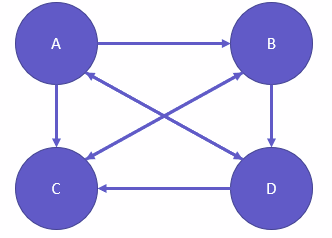

Generate a web system as an RDD of pair tuples (page name, neighbor page name) from a pair rdd (page name, list of all neighbors)
Hint: check out for pair rdd opearations such as, `mapValues` or `flatMapValues`. [Spark reference](https://spark.apache.org/docs/2.2.0/api/python/pyspark.html#pyspark.RDD)

In [ ]:
def map_websystem_rdd(sc: SparkContext, neighbor_rdd: RDD) -> RDD:
    """
    This function gets input web system as rdd and mapping rdd of the system.
    And returns the mapping of the connection between each two web pages
    input:
        sc: spark context
        neighbor_rdd: a pair RDD of the web system contain each web and its links (web page, list of neighbor pages)
    output:
        return a pair RDD that contain all links (web page, neighbor web page)
    """
    # You must use PySpark RDD in part of this solution
    # Your code here
    def get_link_pairs(x):
        page = x[0]
        neighbors = x[1]
        pairs = [(page, neighbor) for neighbor in neighbors]
        return pairs
    websystem_rdd = neighbor_rdd.flatMap(get_link_pairs)
    return websystem_rdd
    raise NotImplementedError()

In [ ]:
neighbor_rdd = sc.parallelize([
                ('a', ['b','c','d']),
                ('c', ['b']), 
                ('b', ['c','d']), 
                ('d', ['a','c'])
              ])

In [ ]:
result = map_websystem_rdd(sc, neighbor_rdd).collect()

In [ ]:
assert result == [
                    ('a', 'b'), ('a', 'c'), ('a', 'd'), 
                    ('c', 'b'), 
                    ('b', 'c'), ('b', 'd'), 
                    ('d', 'a'), ('d', 'c')
                ]

## Kaggle dataset analysis

You can choose whatever data set you like from Kaggle and you need to derive meaningful insights using the Pyspark Dataframe API.
You need to use all the following methods at least one time [DataFrame API](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.html#pyspark.sql.DataFrame):

*   [show](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.show.html#pyspark.sql.DataFrame.show)
*   [printSchema](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.printSchema.html#pyspark.sql.DataFrame.printSchema)
*   [distinct](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.distinct.html#pyspark.sql.DataFrame.distinct)
*   [filter](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.filter.html#pyspark.sql.DataFrame.filter)
*   [foreach](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.foreach.html#pyspark.sql.DataFrame.foreach)
*   [join](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.join.html#pyspark.sql.DataFrame.join)
*   [orderBy](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.orderBy.html#pyspark.sql.DataFrame.orderBy)
*   [sample](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.sample.html#pyspark.sql.DataFrame.sample)
*   [select](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.select.html#pyspark.sql.DataFrame.select)
*   [subtract](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.subtract.html#pyspark.sql.DataFrame.subtract)
*   [where](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.where.html#pyspark.sql.DataFrame.where)
*   [withColumn](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.withColumn.html#pyspark.sql.DataFrame.withColumn)
*   [withColumnRenamed](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.withColumnRenamed.html#pyspark.sql.DataFrame.withColumnRenamed)

In addition, use at least one of the given [functions](https://spark.apache.org/docs/3.1.1/api/python/reference/pyspark.sql.html#functions):
*   [array_contains](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.array_contains.html#pyspark.sql.functions.array_contains)
*   [avg](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.avg.html#pyspark.sql.functions.avg)
*   [collect_set](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.collect_set.html#pyspark.sql.functions.collect_set)
*   [countDistinct](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.countDistinct.html#pyspark.sql.functions.countDistinct)
*   [datediff](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.datediff.html#pyspark.sql.functions.datediff)
*   [min](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.min.html#pyspark.sql.functions.min)
*   [regexp_extract](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.regexp_extract.html#pyspark.sql.functions.regexp_extract)
*   [window](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.window.html?highlight=window)





# Close spark session

In [ ]:
spark.stop()